# Method 4

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nn
from typing import Callable
import time
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from typing import Union

In [52]:
def word_to_vector(word: str, substrings: list) -> np.array:
    array = np.zeros(len(substrings))
    lst = []
    for i, alph in enumerate(substrings):
        lst.append(word.count(alph))
    return np.array(lst)

def word_to_custom_vector(word: str, custom_parameters: list) -> np.array:
    word = word.lower()
    vector = np.zeros(len(custom_parameters))
    for i, parameter in enumerate(custom_parameters):
        if type(parameter) == str:
            vector[i] = word.count(parameter)
        else:
            vector[i] = parameter(word)
    return vector

def suffix_count(name: str, suffix: Union[str, list[str]]) -> int:
    if type(suffix) == list:
        count = 0
        for x in suffix:
            count += suffix_count(name, x)
    else:
        constituents = name.split(' ')
        count = 0
        for word in constituents:
            count += int(word.endswith(suffix))
    return count

def preposition_count(name: str, preposition: Union[str, list[str]]) -> int:
    if type(preposition) == list:
        count = 0
        for x in preposition:
            count += preposition_count(name, x)
    else:
        constituents = name.split(' ')
        count = 0
        for word in constituents:
            count += int(word == preposition)


def uniformize(data_train: pd.DataFrame) -> pd.DataFrame:
    data_train['category'] = data['expected'].apply(np.argmax)
    category_counts = data_train.groupby(data_train['category']).apply(len)
    category_least, category_least_count = np.argmin(category_counts), np.min(category_counts)
    data_train_new = data_train.groupby(data_train['category']).apply(lambda x: x.sample(n=category_least_count))
    data_train_new = data_train_new.reset_index(drop=True)
    data_train_new = data_train_new.sample(frac=1)
    return data_train_new


CZ_ALPHABET = ['a', 'á', 'b', 'c', 'č', 'd', 'ď',
               'e', 'é', 'ě', 'f', 'g', 'h', 'ch',
               'i', 'í', 'j', 'k', 'l', 'm', 'n',
               'ň', 'o', 'ó', 'p', 'q', 'r', 'ř',
               's', 'š', 't', 'ť', 'u', 'ú','ů',
               'v', 'w', 'x', 'y', 'ý','z', 'ž']

VOWELS = ['a', 'á', 'e', 'é', 'ě', 'i', 'í', 'o', 'u', 'ú', 'ů']
CONSONANTS = list(set(CZ_ALPHABET) -  set(VOWELS))

HACKY = ['č', 'ď', 'ě', 'ň', 'ř', 'š', 'ť', 'ž']
CARKY = ['á', 'é', 'í', 'ó', 'ú', 'ů']
MEKKE_SOUHLASKY = ['ž', 'š', 'č', 'ř', 'c', 'j', 'ď', 'ť', 'ň']

CUSTOM = [
    len,
    lambda x: x.count(' ') + 1,
    lambda x: sum(x.count(sub) for sub in VOWELS),
    lambda x: sum(x.count(sub) for sub in CONSONANTS),
    lambda x: sum(x.count(sub) for sub in HACKY),
    lambda x: sum(x.count(sub) for sub in CARKY),
    lambda x: suffix_count(x, 'ov'),
    lambda x: suffix_count(x, 'ín'),
    lambda x: suffix_count(x, 'any'),
    lambda x: suffix_count(x, 'ice'),
    lambda x: suffix_count(x, 'ovice'),
    lambda x: suffix_count(x, 'ec'),
    lambda x: suffix_count(x, MEKKE_SOUHLASKY),
    ' nad ',
    ' pod ',
    ' u ',
    ' v ',
] + CZ_ALPHABET

# set used for vectorization
# SUBSTRINGS = CZ_ALPHABET

In [53]:
VECTORIZATION_FUNC = lambda x: word_to_custom_vector(x, CUSTOM)

data = pd.read_csv('data.csv', encoding = 'ansi', usecols=['Obec', 'Kraj'])

# zbavit se prahy
data = data[data['Obec'] != 'Praha']

data['Obec'] = data['Obec'].str.lower()

data['food'] = data['Obec'].apply(VECTORIZATION_FUNC)

# range from -0.5 to 0.5
food_max = np.max(np.stack(data['food'].values), axis=0)
food_min = np.min(np.stack(data['food'].values), axis=0)
data['food'] = data['food'].apply(lambda x: (x - food_min) / (food_max - food_min) - 0.5)
data['food'] = data['food'].apply(lambda x: np.nan_to_num(x))

LIST_KRAJE = np.sort(data['Kraj'].unique().tolist())
data['expected'] = data['Kraj'].apply(lambda x: word_to_vector(x, LIST_KRAJE))

data.head()

,Obec,Kraj,food,expected
0,abertamy,Karlovarský kraj,"[-0.3125, -0.5, -0.2692307692307692, -0.318181...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,adamov,Jihočeský kraj,"[-0.375, -0.5, -0.2692307692307692, -0.4090909...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,adamov,Jihomoravský kraj,"[-0.375, -0.5, -0.2692307692307692, -0.4090909...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,adamov,Středočeský kraj,"[-0.375, -0.5, -0.2692307692307692, -0.4090909...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,adršpach,Královéhradecký kraj,"[-0.3125, -0.5, -0.34615384615384615, -0.22727...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"


In [54]:
TEST_SIZE = 0.2
data_train = data.sample(frac=(1-TEST_SIZE), random_state=0)
data_test = data.drop(data_train.index)

data_train = uniformize(data_train)

In [84]:
%load_ext autoreload
%autoreload 2

N_INPUT = data_train['food'].iloc[0].shape[0]
N_HIDDEN = 64
N_OUTPUT = data['expected'].iloc[0].shape[0]

ACT_FUNCS = [nn.sigmoid, nn.sigmoid]
COST_FUNC = nn.mean_square

ETA = 5.e-5
N_EPOCHS = 300
BATCH_SIZE = 256

ADAPTIVE_ETA = False
ETA_LIMIT = 1.e-6
ETA_FACTOR = 1.5
CONTINUE_MIN_ETA = True

RANDOM_SEED = 0
MSG_FREQ = 20

network_shape = (N_INPUT, N_HIDDEN, N_OUTPUT)

neural_network = nn.NeuralNetwork(shape=network_shape, act_funcs=ACT_FUNCS, cost_func=COST_FUNC,
                                  eta=ETA, eta_limit=ETA_LIMIT, adaptive_eta=ADAPTIVE_ETA, eta_factor=ETA_FACTOR,
                                  continue_min_eta=CONTINUE_MIN_ETA, random_seed=RANDOM_SEED)

df_stats = neural_network.train(df=data_train[['food', 'expected']], n_epochs=N_EPOCHS,
                                msg_freq=MSG_FREQ, batch_size=BATCH_SIZE, alter_func=None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting training.

[2023-04-12 12:26:43.445894]: Currently at epoch 8/300
Average duration per epoch: 2.53 s.
Estimated time of finishing: 2023-04-12 12:39:03.020574


[2023-04-12 12:27:05.084486]: Currently at epoch 17/300
Average duration per epoch: 2.46 s.
Estimated time of finishing: 2023-04-12 12:38:42.611566


[2023-04-12 12:27:27.492368]: Currently at epoch 26/300
Average duration per epoch: 2.47 s.
Estimated time of finishing: 2023-04-12 12:38:45.208078


[2023-04-12 12:27:48.911988]: Currently at epoch 35/300
Average duration per epoch: 2.45 s.
Estimated time of finishing: 2023-04-12 12:38:37.998483


[2023-04-12 12:28:10.701228]: Currently at epoch 44/300
Average duration per epoch: 2.44 s.
Estimated time of finishing: 2023-04-12 12:38:36.258476


[2023-04-12 12:28:32.273204]: Currently at epoch 53/300
Average duration per epoch: 2.44 s.
Estimated time of finishing: 2023-04-12 12:38:33.88

In [85]:
fig = go.Figure([
    go.Scatter(
        x=df_stats['start'],
        y=df_stats['E_mean'],
        name='E_mean'
    ),
    go.Scatter(
        x=df_stats['start'],
        y=df_stats['acc_train'],
        name='acc_train'
    )
])

fig.show()

In [79]:
neural_network.accuracy(df=data_test[['food', 'expected']])

0.09824281150159744

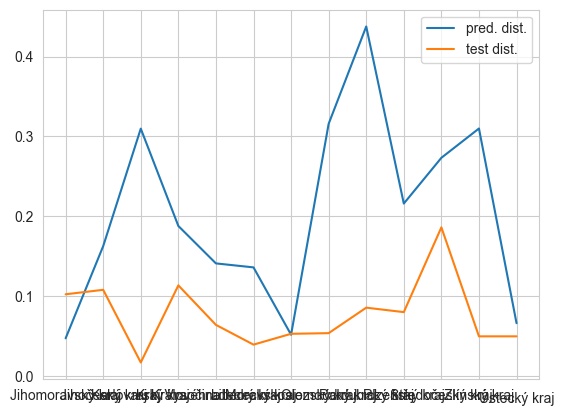

In [48]:
plt.plot(np.sum(data_test['Obec'].apply(lambda x: neural_network.predict(VECTORIZATION_FUNC(x)))) / data_test.shape[0], label='pred. dist.')
plt.plot(data_test.groupby(data_test['Kraj']).apply(len) / data_test.shape[0], label='test dist.')
plt.legend()
plt.show()

In [61]:
nazvy_test = data_train.sample(n=10, random_state=5)

print('Zadání')
print(nazvy_test['Obec'])

print('AI says:')
for nazev in nazvy_test['Obec']:
    food = VECTORIZATION_FUNC(nazev)
    i_predict = np.argmax(neural_network.predict(food))
    print(LIST_KRAJE[i_predict])

print('Correct answers:')
nazvy_test[['Obec', 'Kraj']]

Zadání
272             dobřany
341            radonice
190            traplice
144           fryčovice
0      jílové u držkova
191              ostrov
112                těně
254              příkrý
152            kosořice
287               boseň
Name: Obec, dtype: object
AI says:
Středočeský kraj
Středočeský kraj
Středočeský kraj
Středočeský kraj
Středočeský kraj
Středočeský kraj
Středočeský kraj
Středočeský kraj
Středočeský kraj
Středočeský kraj
Correct answers:


,Obec,Kraj
272,dobřany,Plzeňský kraj
341,radonice,Ústecký kraj
190,traplice,Zlínský kraj
144,fryčovice,Moravskoslezský kraj
0,jílové u držkova,Liberecký kraj
191,ostrov,Karlovarský kraj
112,těně,Plzeňský kraj
254,příkrý,Liberecký kraj
152,kosořice,Středočeský kraj
287,boseň,Středočeský kraj


In [79]:
uniformize(data_train)

,Obec,Kraj,food,expected,category
3,hranice,Olomoucký kraj,"[-0.29411764705882354, -0.47058823529411764, -...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",4
2,voleč,Pardubický kraj,"[-0.3529411764705882, -0.47058823529411764, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",2
5,dolní roveň,Pardubický kraj,"[-0.1764705882352941, -0.4411764705882353, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",8
0,klentnice,Jihomoravský kraj,"[-0.23529411764705882, -0.47058823529411764, -...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0
1,lom,Ústecký kraj,"[-0.4117647058823529, -0.47058823529411764, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",1
6,miřetice,Pardubický kraj,"[-0.2647058823529412, -0.47058823529411764, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",10
4,heřmánky,Moravskoslezský kraj,"[-0.2647058823529412, -0.47058823529411764, -0...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",6


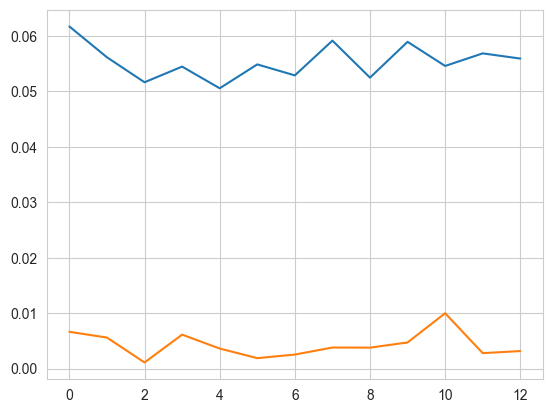

In [100]:
category_distribution = data.sort_values(by='Kraj').groupby(data['Kraj']).count()['Obec'].reset_index(drop=True) / data.shape[0]
predictions = []

for obec in data_test['Obec']:
    prediction = neural_network.predict(word_to_custom_vector(obec, custom_parameters=CUSTOM))
    predictions.append(prediction)
    # plt.plot(prediction, color='grey')

plt.plot(np.mean(predictions, axis=0))
plt.plot(category_distribution * np.mean(predictions, axis=0))
plt.show()
# plt.plot(category_distribution)

In [101]:
neural_network.accuracy(df=data_test[['food', 'expected']])

0.07108626198083066